# <center>  Notebook S02. Fredholm Integral Equation </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 

This notebook introduces the Fredholm integral equation and derives the discretized solution via the forward convolution matrix. The notebook is a supplement to the manuscript <br>

Petters, M. D. (2018) <i> A language to simplify interpretation of differential mobility analyzer response functions</i>, Aerosol Science & Technology, 52 (12), 1437-1451. <br><br>

### Transmission through the DMA at Constant Voltage

Figure 1 shows a schematic instrument setup with an array of detectors. The DMA is operated in classifier mode and set to a single voltage. The mobility classified particles are then passed to one or more detectors. 
<img src="Figures/nbs2_f01.png" width="350" align = "middle">
<figcaption><b> Figure 1. </b> Illustration of the combined transfer function through the DMA. </figcaption> 

At constant v the DMA selects mobility "z star" ($z^s$) based on DMA geometery and voltage (also see Notebook 1).<br><br>

<center> $z^s = \frac{q_{sh}}{2\pi l v} \ln \left(\frac{r_2}{r_1}\right)$ </center> <br> 

The relationship between physical diameter $D[z^s,k]$ and number of charges is (also see Notebook 1) <br><br>

<center> $D[z^s,k] =  \frac{kec_c}{3\pi \eta z^s}$ </center> <br>
The charge fractions $T_c(D[z^s,k])$ and diffusional loss in the DMA $T_l(D[z^s,k])$ are computed based on the physical diameter. A convenient transformation is to define <br><br>

<center> $z_k^s = \frac{z^s}{k}$ </center> <br>

which leads to the computational identity <br><br>
<center> $D[z_k^s,1] = D[z^s,k]$ </center> <br>

Transfer through the DMA for k charged particles is given by <br><br>
<center> $\Omega(Z, z_k^s)$ </center> <br>
    
where Z is a vector of transmitted mobilities. For k > 1 $\Omega(Z, z_k^s)$ selects particles of lower mobility and thus larger size. The net transfer through the DMA can thus be written as <br><br>
    
<center> $T = \Omega(Z, z_k^s)T_c(D[Z,1])T_l(D[Z,1])$ </center> <br>
       
In this form, the net transmission vector through the DMA is readily computed. Table 1 summarizes these functions and demonstrates how they are represented in the code. 
<center>
<table>
    <caption> <b> Table 1. </b> Code representation of convolution functions. </caption>
  <col width="110">
  <col width="80">
  <col width="130">
  <col width="200">
<tr>
    <th >Quantity</th>
    <th >Code</th> 
    <th >Reference</th>
    <th >Notes</th> 
</tr>
  <tr>
    <td>$D[Z,k]$</td>
    <td>ztod(Œõ,k,Z)</td> 
    <td>Nb.S1.B3c</td>
    <td>Nb.S1.B3c means compare Notebook S1 Block 3c</td> 
</tr>
  <tr>
    <td>$T_l(D[Z,k])$</td>
    <td>Œ¥.Tl(Œõ,D[Z,k])</td> 
    <td>Nb.S1.B3d</td>
    <td>d is in nm and Œõ is a structure that contains flow rates</td> 
</tr>
  <tr>
    <td>$T_c(D[Z,k])$</td>
    <td>Œ¥.Tc(k,D[Z,k])</td> 
    <td>Nb.S1.B3e</td>
    <td></td> 
  </tr>
  <tr>
    <td>$\Omega(z,z_k^s)$</td>
    <td>Œ¥.Œ©(Œõ,z,$z_k^s$) </td> 
    <td>Nb.S1.B3f</td>
    <td>with $z^s$ = vtoz(Œõ,v) <br>
        and $z_k^s = \frac{z^s}{k}$</td> 
  </tr>
</table>
</center>

A step-by-step illustration of the transmission function $T$ is presented next.

## Block 1. Dependencies

In [1]:
using Plots, Plots.PlotMeasures, DataFrames, DifferentialMobilityAnalyzers
plotlyjs();   

‚îå Info: Recompiling stale cache file /home/mdpetter/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
‚îî @ Base loading.jl:1184
‚îå Info: Recompiling stale cache file /home/mdpetter/.julia/compiled/v1.1/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
‚îî @ Base loading.jl:1184
‚îå Info: Precompiling DifferentialMobilityAnalyzers [050a7be8-18f9-52d6-bdba-0a194485d082]
‚îî @ Base loading.jl:1186
‚îå Info: Recompiling stale cache file /home/mdpetter/.julia/compiled/v1.1/PlotlyJS/1r9Ld.ji for PlotlyJS [f0f68f2c-4968-5e81-91da-67840de0976a]
‚îî @ Base loading.jl:1184


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7446044710596094428\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6042387611858652498\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/2543b61946cfbfb279b4f01ff6b02977f9fcee1b-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-7446044710596094428\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

## Block 2. Setup the DMA 
The Œõ structures define the DMA in terms of flow rates and geometry and power supply polarity. Geometry parameters correspond to the TSI 3080 long column. The effective diffusion length describes diffusional loss in the DMA column (Reineking & Porstend√∂rfer, 1986) which is described further below. Diffusional loss is ignored if ```leff = 0```. The Œõ variable is used in various functions to define the state of the DMA.

In [2]:
t,p = 296.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,Œ≤ = 1.66e-5, 1/5                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r‚ÇÅ,r‚ÇÇ,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 6                                            # Upper number of charges
DMAtype = :cylindrical                           # Select DMA geometry
Œõ = DMAconfig(t,p,qsa,qsa/Œ≤,r‚ÇÅ,r‚ÇÇ,l,leff,:-,m,DMAtype)   # Specify DMA with negative polarity
bins,z‚ÇÅ,z‚ÇÇ = 512, dtoz(Œõ,1000e-9), dtoz(Œõ,10e-9) # bins, upper, lower mobility limit
Œ¥ = setupDMA(Œõ, z‚ÇÅ, z‚ÇÇ, bins);                   # Compute matrices

## Block 3. Transmission Function 
### Step 1: Mobility Selection
A single mobility zÀ¢ is selected and plotted over the mobility vector $Z$. The mobility vector corresponds to the $i$ response channels of the DMA.

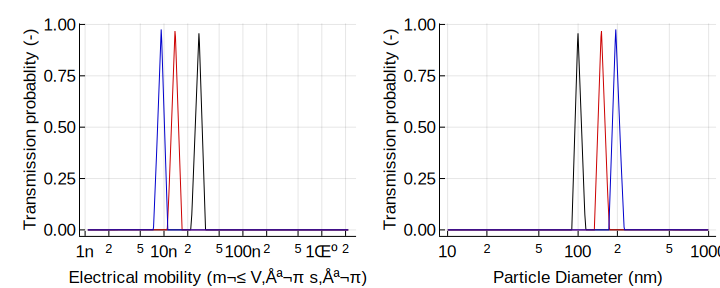

In [3]:
figure("Nimbus Sans L", 2, 5, 2, 8)             # Figure setup for all figures below
zÀ¢ = dtoz(Œõ,100e-9)                         # Pick a mobility and evaluate over grid

p1 = plot(Œ¥.Z, Œ¥.Œ©(Œõ,Œ¥.Z,zÀ¢), xaxis = :log10, legend = :none, color = :black, left_margin = 10px, 
    xlabel = "Electrical mobility (m¬≤ V‚Åª¬π s‚Åª¬π)", ylabel = "Transmission probablity (-)")
p1 = plot!(Œ¥.Z, Œ¥.Œ©(Œõ,Œ¥.Z,zÀ¢/2), color = RGBA(0.8,0,0,1))
p1 = plot!(Œ¥.Z, Œ¥.Œ©(Œõ,Œ¥.Z,zÀ¢/3), color = RGBA(0,0,0.8,1))

p2 = plot(Œ¥.Dp, Œ¥.Œ©(Œõ,Œ¥.Z,zÀ¢), xaxis = :log10, legend = :none, color = :black, left_margin = 10px, 
    xlabel = "Particle Diameter (nm)", ylabel = "Transmission probablity (-)")
p2 = plot!(Œ¥.Dp, Œ¥.Œ©(Œõ,Œ¥.Z,zÀ¢/2), color = RGBA(0.8,0,0,1))
p2 = plot!(Œ¥.Dp, Œ¥.Œ©(Œõ,Œ¥.Z,zÀ¢/3), color = RGBA(0,0,0.8,1))
plot(p1,p2, grid = (2,1), fmt = :svg)

<figcaption><b> Figure 2. </b> Single mobility selection using ```Œ©(Œõ,Z,zÀ¢)```. Left: transmission vs. mobility, right: transmission vs. particle diameter. Black,red, and blue corresponds to +1,+2, and +3 charges, respectively. </figcaption> 

### Step 2. Charge Filter
The charge filter function computes the charge fraction as a function of diameter and number of charges k. Note that the diameters ```Œ¥.Dp``` map directly to the mobility vector ```Z``` assuming k = 1 charge (i.e. ```Dp = ztod(Œõ,1,Z)```).

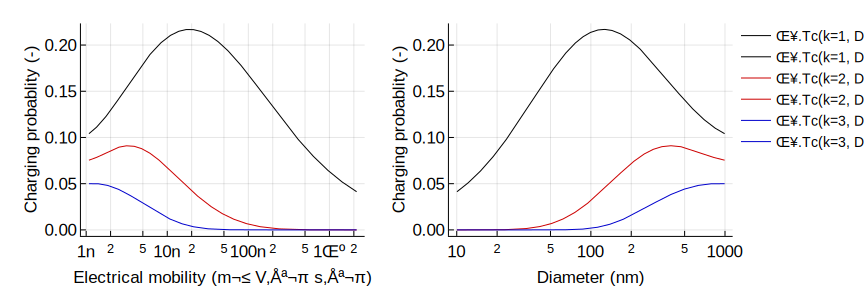

In [4]:
figure("Nimbus Sans L", 2, 6, 2, 8)  
k = 1
p1 = plot(Œ¥.Z, Œ¥.Tc(k,Œ¥.Dp), xaxis = :log10, label = "Œ¥.Tc(k=$k, Dp)",  color = :black, left_margin = 25px,
    xlabel = "Electrical mobility (m¬≤ V‚Åª¬π s‚Åª¬π)", ylabel = "Charging probablity (-)")
k = 2
p1 = plot!(Œ¥.Z, Œ¥.Tc(k,Œ¥.Dp), xaxis = :log10, label = "Œ¥.Tc(k=$k, Dp)",  color = RGBA(0.8,0,0,1))
k = 3
p1 = plot!(Œ¥.Z, Œ¥.Tc(k,Œ¥.Dp), xaxis = :log10, label = "Œ¥.Tc(k=$k, Dp)",  color = RGBA(0,0,0.8,1))

k = 1
p2 = plot(Œ¥.Dp, Œ¥.Tc(k,Œ¥.Dp), xaxis = :log10, label = "Œ¥.Tc(k=$k, Dp)",  color = :black, left_margin = 25px,
    xlabel = "Diameter (nm)", ylabel = "Charging probablity (-)")
k = 2
p2 = plot!(Œ¥.Dp, Œ¥.Tc(k,Œ¥.Dp), xaxis = :log10, label = "Œ¥.Tc(k=$k, Dp)",  color = RGBA(0.8,0,0,1))
k = 3
p2 = plot!(Œ¥.Dp, Œ¥.Tc(k,Œ¥.Dp), xaxis = :log10, label = "Œ¥.Tc(k=$k, Dp)",  color = RGBA(0,0,0.8,1))

plot(p1,p2, grid = (2,1), fmt = :svg)

<figcaption><b> Figure 3. </b> Charging probability functions as a function of electrical mobility (left) and diameter(right), ```Tc(k,Dp)```, for k = 1,2,3. </figcaption> 

### Step 3. Overall Transmission Function 
The diffusional transmission filter computes the penetration efficiency as a function of diameter and number of charges k. Note that the diameters ```Œ¥.Dp``` map directly to the mobility vector ```Z``` assuming k = 1 charge (i.e. ```Dp = ztod(Œõ,1,Z)```).

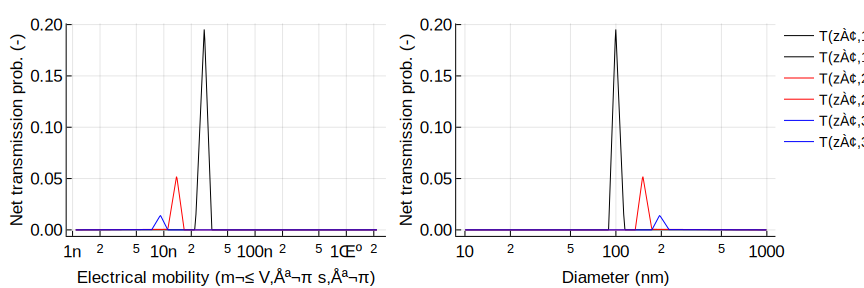

In [5]:
T = (zÀ¢,k,Œõ,Œ¥) -> Œ¥.Œ©(Œõ,Œ¥.Z,zÀ¢/k).*Œ¥.Tc(k,Œ¥.Dp).*Œ¥.Tl(Œõ,Œ¥.Dp);  # DMA Transmission (Notebook 2)
p1 = plot(Œ¥.Z, T(zÀ¢,1,Œõ,Œ¥) , xaxis = :log10,label = "T(zÀ¢,1)", color = :black,
    xlabel = "Electrical mobility (m¬≤ V‚Åª¬π s‚Åª¬π)", ylabel = "Net transmission prob. (-)")
p1 = plot!(Œ¥.Z, T(zÀ¢,2,Œõ,Œ¥), xaxis = :log10, label = "T(zÀ¢,2)",  color = :red)
p1 = plot!(Œ¥.Z, T(zÀ¢,3,Œõ,Œ¥), xaxis = :log10, label = "T(zÀ¢,3)",  color = :blue)

p2 = plot(Œ¥.Dp, T(zÀ¢,1,Œõ,Œ¥), xaxis = :log10, label = "T(zÀ¢,1)", color = :black,
    xlabel = "Diameter (nm)", ylabel = "Net transmission prob. (-)")
p2 = plot!(Œ¥.Dp, T(zÀ¢,2,Œõ,Œ¥), xaxis = :log10, label = "T(zÀ¢,2)",  color = :red)
p2 = plot!(Œ¥.Dp, T(zÀ¢,3,Œõ,Œ¥), xaxis = :log10, label = "T(zÀ¢,3)",  color = :blue)

plot(p1,p2, grid = (2,1), fmt = :svg)

<b> Figure 4. </b> Net transmission probablity due to DMA transfer function, charging probability, and transmission probability expressed as the convolution function 
 
 ```julia
  T = (zÀ¢,k,Œõ,Œ¥) -> Œ¥.Œ©(Œõ,Œ¥.Z,zÀ¢/k).*Œ¥.Tc(k,Œ¥.Dp).*Œ¥.Tl(Œõ,Œ¥.Dp)
 ``` 
 
 for k = 1,2,3.

## Block 4. Size Distribution Measurement
A size distribution is obtained by systematically stepping through voltages (or zÀ¢). Figure 5 shows an example setup where concentration at the exit of the DMA is measured with a condensation particle counter (CPC), here assumed to operate with unit efficiency. During the experiment the voltage is scanned to cover a range in electrical mobility. The response function is binned, resulting in the  vector $R$, where $R_i$ is the response in instrument channel $i$ and is expressed as number concentration per unit volume. The response vector is sometimes plotted against the mobility diameter ($D[Z,1]$) assuming singly charged particle. The response vector can be computed multiplication of the true size distribution vector $N$ with a convolution matrix $\mathbf{A}$ derived below. <br> 

<img src="Figures/nbs2_f02.png" width="750" align = "middle">
<figcaption><b> Figure 5. </b> Illustration of the relationship between the discretized true size distribution and the DMA response function.</figcaption> 



### Convolution Intergral
The DMA response vector is obtained via the Fredholm integral equation of the first kind (e.g. Kandlikar and  Ramachandran, 1999, Stolzenburg and McMurry, 2008, Petters et al. 2007,2009). <br><br>

 <center> $ R_i = \int_{z_a}^{z_b} \sum_{k=1}^n \Omega(z,Z_{i,k}^s)T_c(D[z,1])T_l(D[z,1])\frac{dN}{d\ln D}\frac{d \ln D}{dz}dz + \epsilon_i\;\;\;\; i = 1,2...,n$   </center>
 
The integral is performed over the limits $z_a$ and $z_b$, which corresponds to the upper and lower mobility limit set by the voltage range used to operate the DMA. The function $\frac{dN}{d\ln D}\frac{d\ln D}{dz}dz$ evaluates to the number concentration of particles that lie in the interval $[z,z + dz]$. Note that $D[z,1]$ is used in the charge filter and loss function since the integral is applied over the transform of the selected centroid mobility $Z_{i,k}^s$ (see above). $Z$ is the mobility vector of the grid and the subscript $i$ denotes the channel response channel. Finally, $\epsilon_i$ is the detector error in channel $i$. The convolution integral can be discretized:  <br><br>

 <center> $ R_i = \sum_{j=1}^n \left [ \sum_{k=1}^m \Omega(Z_j,Z_{i,k}^s)T_c(D[Z_j,1])T_l(D[Z_j,1])N(Z_j) \right] + \epsilon_i$</center> <br>
$N(Z_j)$ is the the number concentration of particles in the $j^{th}$ bin, $i = 1...n$
are indices the observed instrument channel, $j = 1...n$ are indices of the physical size bins, and $k = 1...m$ are indices of charges carried by the particle. Here it is assumed that $\Omega(Z_j,Z_{i,k}^s)$ can be approximated being constant over the bin $[Ze_{j},Ze_{j+1}]$, which is only true if a sufficiently large number of size bins is used. The discretized version represents a set of $n$ equations that can be written in matrix form <br><br>

<center> 
$ \begin{bmatrix}
       R_1    \\
       \vdots \\        
       R_n
\end{bmatrix} =
\begin{pmatrix}
  \sum_{k=1}^m \Omega(Z_1,Z_{1,k}^s)T_c(D[Z_1,1])T_l(D[Z_1,1])  & \cdots & \sum_{k=1}^m \Omega(Z_n,Z_{1,k}^s)T_c(D[Z_n,1])T_l(D[Z_n,1]) \\
  \vdots  & \ddots  & \vdots  \\
  \sum_{k=1}^m \Omega(Z_1,Z_{n,k}^s)T_c(D[Z_1,1])T_l(D[Z_1,1])  & \cdots & \sum_{k=1}^m \Omega(Z_n,Z_{n,k}^s)T_c(D[Z_n,1])T_l(D[Z_n,1])  
\end{pmatrix}
\begin{bmatrix}
       N_1    \\[0.3em]
       \vdots \\[0.3em]        
       N_n
\end{bmatrix}
+
\begin{bmatrix}
       \epsilon_1    \\[0.3em]
       \vdots \\[0.3em]        
       \epsilon_n
\end{bmatrix}$</center>

which is equivalent to

<center> $R = \mathbf{A}N + \epsilon_i$ </center> <br>
where $R$ is the response vector (right panel Figure 1), $\mathbf{A}$ is the convolution matrix, and $N$ is the discretized true number concentration (left panel Figure 5). Below it is shown how to the matrix is applied, and how it is computed within the code. Correctness of the matrix is shown in Notebook 6.


### Example Calculation

In [6]:
t,p = 296.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,Œ≤ = 1.66e-5, 1/5                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r‚ÇÅ,r‚ÇÇ,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 6                                            # Upper number of charges
DMAtype = :cylindrical
Œõ = DMAconfig(t,p,qsa,qsa/Œ≤,r‚ÇÅ,r‚ÇÇ,l,leff,:-,m,DMAtype) # Specify DMA with negative polarity
bins,z‚ÇÅ,z‚ÇÇ = 512, dtoz(Œõ,1000e-9), dtoz(Œõ,10e-9) # bins, upper, lower mobility limit
Œ¥ = setupDMA(Œõ, z‚ÇÅ, z‚ÇÇ, bins);                   # Compute matrices

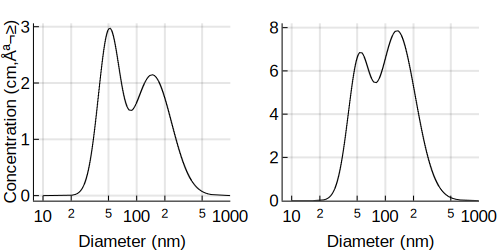

In [7]:
ùïü = DMALognormalDistribution([[230, 50, 1.3], [280, 140, 1.6]],Œ¥)
figure("Nimbus Sans L", 2, 3.5, 1.75, 8)
p1 = plot(ùïü.Dp, ùïü.N, xaxis = :log10, xticks = [10, 100, 1000], legend = :none, right_margin = 35px, 
    ylabel = "Concentration (cm‚Åª¬≥)", xlim = (8,1000), color =  :black, xlabel = "Diameter (nm)", lt = :steppre)

p2 = plot(ùïü.Dp, Œ¥.ùêÄ*ùïü.N, legend = :none,  xaxis = :log10, right_margin = 25px, lt = :steppre,ylim = (0,8.2),
     xlim = (8,1000), color =  :black, xlabel = "Diameter (nm)")

plot(p1,p2,grid=(1,2), fmt = :svg)

<figcaption><b> Figure 6. </b> Illustration of computation of the response function. Distributions are the same as in Figure 5 but at higher bin resolution. Left: true size distribution, right response function calculated via Œ¥.ùêÄ*ùïü.N. See for Notebook 3 for detailed explanation of the size distribution data type.</figcaption> 

## Block 5. Computation of Convolution Matrix
This section demonstrates how the convolution matrices are computed in DifferentialMobilityAnalyzer.jl. For a given z vector, the matrix can be computed essentially with a single command and the user defined function Œ£

```julia
Œ£ = (f,i) -> mapreduce(f,+,1:i)
T = (zÀ¢,k,Œõ,Œ¥) -> Œ¥.Œ©(Œõ,Œ¥.Z,zÀ¢/k).*Œ¥.Tc(k,Œ¥.Dp).*Œ¥.Tl(Œõ,Œ¥.Dp)
ùêÄ=(hcat(map(zÀ¢->Œ£(k->T(zÀ¢,k,Œõ,Œ¥),Œõ.m),Œ¥.Z)...))'
```

The segements below explain the commands step-by-step. As demonstrated above
```julia 
T = (zÀ¢,k,Œõ,Œ¥) -> Œ¥.Œ©(Œõ,Œ¥.Z,zÀ¢/k).*Œ¥.Tc(k,Œ¥.Dp).*Œ¥.Tl(Œõ,Œ¥.Dp)
```
selects for a single mobility zÀ¢ and charge k. The function 
```julia
Œ£ = (f,i) -> mapreduce(f,+,1:i)```
sums functions that take a single argument and apply it for the array 1:i. For example Œ£(x->x^2,4) = 1^2 + 2^2 + 3^2 + 4^2 = 30 or Œ£(exp,2) = exp(1) + exp(2) = 10.107. In the context above 
```julia 
y = Œ£(k->T(zÀ¢,k,Œõ,Œ¥),3)
```
will compute ```T(zÀ¢,1,Œõ,Œ¥)+T(zÀ¢,2,Œõ,Œ¥)+T(zÀ¢,3,Œõ,Œ¥)``` and return an array of transmission efficiencies.

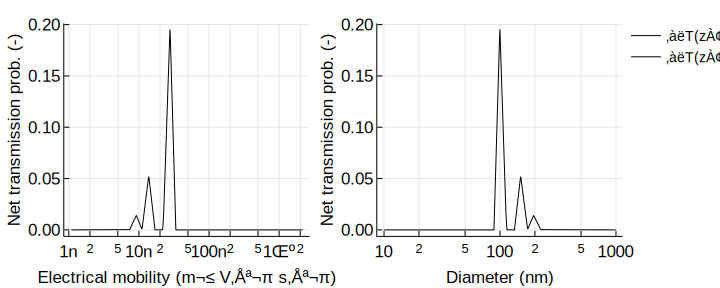

In [8]:
figure("Nimbus Sans L", 2, 5, 2, 8)  
y = Œ£(k->T(zÀ¢,k,Œõ,Œ¥),3)
p1 = plot(Œ¥.Z, y, xaxis = :log10, 
    label = "‚àëT(zÀ¢,k)", color = :black, xlabel = "Electrical mobility (m¬≤ V‚Åª¬π s‚Åª¬π)", 
    ylabel = "Net transmission prob. (-)")

p2 = plot(Œ¥.Dp, y, xaxis = :log10, label = "‚àëT(zÀ¢,k)", color = :black,
    xlabel = "Diameter (nm)", ylabel = "Net transmission prob. (-)")

plot(p1,p2, grid = (2,1), fmt = :svg)

<figcaption><b> Figure 7. </b> Same as Figure 4, but multiple charge contributions are combined into a single array. </figcaption> 

The command 
```julia
map(zÀ¢->Œ£(k->T(zÀ¢,k,Œõ,Œ¥),Œõ.m),Œ¥.Z)```

computes the above curve for all zÀ¢/k ‚àà Z, i.e. each bin midpoint from the z-array The length of Z is number of bins. For each Z value, the expression produces an array with length equals to the number of bins. The resulting output is an array of arrays.

In [9]:
x = map(zÀ¢->Œ£(k->T(zÀ¢,k,Œõ,Œ¥),Œõ.m),Œ¥.Z)
println(typeof(x))               # What data type
println(size(x))                 # Length of x 
println(size(x[1]))              # Length of x[1], x[2], ...

Array{Array{Float64,1},1}
(512,)
(512,)


To demonstrate how arrays of arrays work, here is an example.

In [10]:
test = Array{Float64}[]
push!(test,[1,2,3])
push!(test,[5,6,4])
test

2-element Array{Array{Float64,N} where N,1}:
 [1.0, 2.0, 3.0]
 [5.0, 6.0, 4.0]

In julia, the splatting operator will pass all elements of an array to a function. For example

In [11]:
fun = (a,b,c)->a+b+c # A function with three inputs
x = [1,2,3]          # an array of three numbers
fun(x...)            # fun(x...) = fun(x[1],x[2],x[3])

6

Applied to the test array:

In [12]:
hcat(test...)        # hcat(test...) = hcat(test[1], test[2]). Note that hcat takes any number of inputs

3√ó2 Array{Float64,2}:
 1.0  5.0
 2.0  6.0
 3.0  4.0

Above 
```julia 
x = map(zÀ¢->Œ£(k->T(zÀ¢,k,Œõ,Œ¥),Œõ.m),Œ¥.Z)```

x[1], ... x[512] are the rows of the convolution matrix. To arrange the Array{Array} in the form of a matrix, hcat + splatting is used. Finally the ()' transposes the matrix to get it into the correct orientation.

In [13]:
ùêÄ = (hcat(map(zÀ¢->Œ£(k->T(zÀ¢,k,Œõ,Œ¥),Œõ.m),Œ¥.Z)...))'

512√ó512 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.100079     0.0937158    0.0863586    ‚Ä¶  0.0          0.0        
 0.0934605    0.100466     0.0940936       3.61387e-14  1.96406e-73
 0.0861216    0.0938279    0.100865        3.64087e-14  1.97872e-73
 0.0788909    0.0864601    0.0942062       3.66802e-14  1.93093e-34
 0.0717671    0.079201     0.0868086       0.0          3.6366e-14 
 0.0647484    0.0720492    0.0795203    ‚Ä¶  2.07541e-99  3.66372e-14
 0.0578333    0.0650029    0.0723396       3.75078e-14  1.9745e-34 
 0.0510203    0.0580606    0.065265        2.43823e-19  0.0        
 0.0443079    0.0512209    0.0582947       0.0          2.06901e-73
 0.0376946    0.0444821    0.0514274       3.8354e-14   2.01904e-34
 0.031179     0.0378428    0.0446614    ‚Ä¶  0.0          3.80252e-14
 0.0247595    0.0313015    0.0379954       0.0          2.0493e-34 
 0.0184348    0.0248568    0.0314277       0.0          0.0        
 ‚ãÆ                                      ‚ã±  ‚ãÆ  

### Other Matrices
The full transmission function through the DMA is given by
```julia
Œ¥.Œ©(Œõ,Œ¥.Z,i/k).*Œ¥.Tc(k,Œ¥.Dp).*Œ¥.Tl(Œõ,Œ¥.Dp)
```
Modifying this expression allows constructing other matrices. For example, consider the case where particles with known mobility are supplied to a second DMA. There is no bipolar charger.  In this case the function Œ¥.Tc(k) is not used. Since nothing is known about the particle mass/charge ratio, and the split within the population, all particles are assumed to be +1 charged. The only error in this assumption is that the multiply charged particles hiding in the mobility peak may have a different loss rate Tl, which does not vary strongly with size except for very small particles. To describe this process, the transmission matrix O is defined as
```julia
ùêé = (hcat(map(i->Œ£(k->Œ¥.Œ©(Œõ,Œ¥.Z,i/k).*Œ¥.Tl(Œõ,Œ¥.Dp),1),Œ¥.Z)...))'
```
which is similar to ùêÄ but with Œõ.n = 1 and Œ¥.Tc(k) omitted. The matrix ùêé is used to describe size selection in tandem DMA systems where no charge neutralization is used between DMA1 and DMA2 (see Notebooks S8,S9).

In [14]:
ùêé = (hcat(map(i->Œ£(k->Œ¥.Œ©(Œõ,Œ¥.Z,i/k).*Œ¥.Tl(Œõ,Œ¥.Dp),1),Œ¥.Z)...))'

512√ó512 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.961405     0.896743     0.823017     ‚Ä¶  0.0          0.0        
 0.897824     0.961336     0.896734        8.68042e-13  0.0        
 0.827322     0.897815     0.961267        8.74522e-13  0.0        
 0.757862     0.827314     0.897807        8.8105e-13   0.0        
 0.689427     0.757855     0.827306        0.0          8.80809e-13
 0.622002     0.68942      0.757847     ‚Ä¶  0.0          8.87384e-13
 0.555573     0.621996     0.689414        9.00927e-13  0.0        
 0.490124     0.555568     0.62199         0.0          0.0        
 0.425642     0.49012      0.555562        0.0          0.0        
 0.362112     0.425638     0.490115        9.21253e-13  0.0        
 0.299519     0.362108     0.425634     ‚Ä¶  0.0          9.21001e-13
 0.237851     0.299516     0.362105        0.0          0.0        
 0.177093     0.237849     0.299514        0.0          0.0        
 ‚ãÆ                                      ‚ã±  ‚ãÆ  

## References

Kandlikar, M., & Ramachandran, G. (1999) Inverse methods for analysing aerosol spectrometer measurements: A critical review. Journal of Aerosol Science, 30(4), 413-437, DOI: 10.1016/S0021-8502(98)00066-4. <br>

Petters, M. D., A. J. Prenni, S. M. Kreidenweis, P. J. DeMott (2007) On measuring the critical diameter of cloud condensation nuclei using mobility selected aerosol, Aerosol Science and Technology, 41(10), 907-913, doi:10.1080/02786820701557214. 

Petters, M. D., C. M. Carrico, S. M. Kreidenweis, A. J. Prenni, P. J. DeMott, J. R. Collett Jr., and H. Moosm√ºller (2009) Cloud condensation nucleation ability of biomass burning aerosol, Journal of Geophys Research, 114, D22205, DOI:10.1029/2009JD012353.

Reineking, A. & J. Porstend√∂rfer (1986) Measurements of Particle Loss Functions in a Differential Mobility Analyzer (TSI, Model 3071) for Different Flow Rates, Aerosol Science and Technology, 5:4, 483-486, DOI: 10.1080/02786828608959112. <br> 

Stolzenburg, M. R. & P. H. McMurry (2008) Equations Governing Single and Tandem DMA Configurations and a New Lognormal Approximation to the Transfer Function, Aerosol Science and Technology, 42:6, 421-432, DOI: 10.1080/02786820802157823